In [1]:
import sys
sys.path.insert(0, '../src/')

In [47]:
import glob
import os
import itertools
import subprocess
import tempfile

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import umap
import logomaker
from ipywidgets import Dropdown, VBox
from IPython.display import display, clear_output
from python_pdb.aligners import align_pandas_structure
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_structure_tools.imgt_numbering import assign_cdr_number
from tcr_pmhc_structure_tools.paths import STCRDAB_PATH
from tcr_pmhc_structure_tools.processing import annotate_tcr_pmhc_df

In [3]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/structure-pw-distances'

In [4]:
with open(os.path.join(DATA_DIR, 'structure_names.txt'), 'r') as fh:
    structure_names = [line.strip() for line in fh.readlines()]

In [29]:
df = pd.DataFrame()

for path in glob.glob(os.path.join(DATA_DIR, '*_distance_matrix.txt')):
    name = os.path.basename(path).replace('_distance_matrix.txt', '')
    
    cdr, chain = name.split('_')
    
    cdr_distance_matrix = np.loadtxt(path)
    cdr_distance_matrix = np.maximum(cdr_distance_matrix, cdr_distance_matrix.transpose())
    
    cdr_clusters = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(cdr_distance_matrix)

    cdr_umap = umap.UMAP(metric='precomputed').fit_transform(cdr_distance_matrix)
    
    cdr_df = pd.DataFrame({
        'name': structure_names,
        'cluster': cdr_clusters,
        'umap_1': cdr_umap[:, 0],
        'umap_2': cdr_umap[:, 1],
    })
    cdr_df['chain_type'] = chain + '_chain'
    cdr_df['cdr'] = cdr.replace('cdr', '')
    
    df = pd.concat([df, cdr_df])

df

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/u

name  cluster     umap_1    umap_2   chain_type cdr
0    7rk7_DE       -1  13.133016 -3.630574   beta_chain   3
1    7s8i_AB       27  10.244699  6.051099   beta_chain   3
2    7s8j_AB       -1   9.968904  0.727889   beta_chain   3
3    3qux_CD       18  15.138021  4.246182   beta_chain   3
4    2z31_AB       -1  10.503674  6.423481   beta_chain   3
..       ...      ...        ...       ...          ...  ..
752  7sg2_DE        4   5.713958  3.887192  alpha_chain   3
753  6miv_CD        7  15.203861  7.048450  alpha_chain   3
754  3rtq_CD        7  14.686299  5.760192  alpha_chain   3
755  1d9k_AB       -1   2.620293  4.143442  alpha_chain   3
756  4gg6_GH       -1   5.563297  4.444456  alpha_chain   3

[4542 rows x 6 columns]

In [30]:
df['cluster'] = df['cluster'].apply(str)
df['cluster'] = df['cluster'].replace('-1', 'noise')

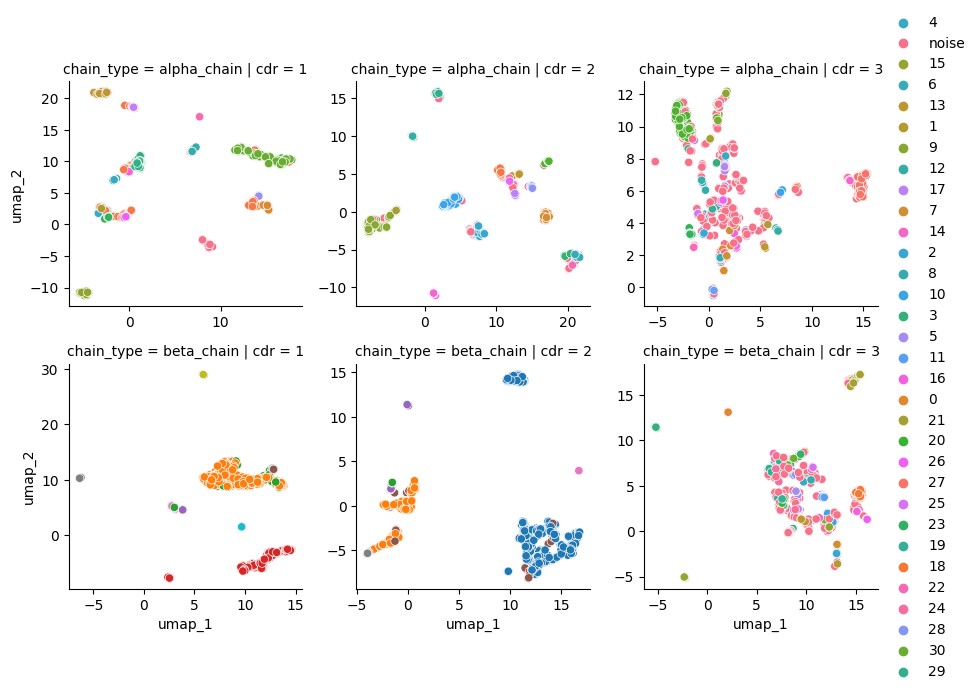

In [31]:
g = sns.FacetGrid(df.sort_values(['chain_type', 'cdr']), row='chain_type', col='cdr', sharex=False, sharey=False)
g.map(sns.scatterplot, 'umap_1', 'umap_2', 'cluster')
g.add_legend()

In [32]:
df.groupby(['chain_type', 'cdr'])['cluster'].value_counts()

chain_type   cdr  cluster
alpha_chain  1    9          180
                  noise      117
                  17          77
                  15          67
                  6           60
                            ... 
beta_chain   3    24           7
                  25           7
                  26           7
                  0            7
                  22           6
Name: count, Length: 117, dtype: int64

# Add sequences for each loop

In [11]:
structures = pd.DataFrame({
    'name': df['name'].unique(),
})

structures

name
0    7rk7_DE
1    7s8i_AB
2    7s8j_AB
3    3qux_CD
4    2z31_AB
..       ...
752  7sg2_DE
753  6miv_CD
754  3rtq_CD
755  1d9k_AB
756  4gg6_GH

[757 rows x 1 columns]

In [12]:
structures[['pdb_id', 'chains']] = structures['name'].str.split('_').apply(pd.Series)
structures[['alpha_chain_id', 'beta_chain_id']] = structures['chains'].apply(list).apply(pd.Series)

structures

name pdb_id chains alpha_chain_id beta_chain_id
0    7rk7_DE   7rk7     DE              D             E
1    7s8i_AB   7s8i     AB              A             B
2    7s8j_AB   7s8j     AB              A             B
3    3qux_CD   3qux     CD              C             D
4    2z31_AB   2z31     AB              A             B
..       ...    ...    ...            ...           ...
752  7sg2_DE   7sg2     DE              D             E
753  6miv_CD   6miv     CD              C             D
754  3rtq_CD   3rtq     CD              C             D
755  1d9k_AB   1d9k     AB              A             B
756  4gg6_GH   4gg6     GH              G             H

[757 rows x 5 columns]

In [13]:
def get_sequence(df):
    residue_names = df.drop_duplicates(['chain_id', 'residue_seq_id', 'residue_insert_code'])['residue_name']
    return ''.join(residue_names.map(THREE_TO_ONE_CODE).tolist())

In [14]:
def get_cdr_sequences(pdb_id, alpha_chain_id, beta_chain_id):
    with open(os.path.join(STCRDAB_PATH, 'imgt', pdb_id + '.pdb'), 'r') as fh:
        structure_df = parse_pdb_to_pandas(fh.read())
    
    structure_df = annotate_tcr_pmhc_df(structure_df, alpha_chain_id, beta_chain_id)
    tcr_df = structure_df.query('chain_type.notnull()')
    
    cdr_sequences = tcr_df.groupby(['chain_type', 'cdr']).apply(get_sequence)
    cdr_sequences.name = 'sequence'
    
    index = cdr_sequences.index.to_flat_index()
    index = index.map(lambda index: f"cdr_{'a' if index[0] == 'alpha_chain' else 'b'}{int(index[1])}_sequence")
    cdr_sequences.index = index
    
    return cdr_sequences

In [15]:
structures = pd.concat([structures,
                        structures.apply(
                            lambda row: get_cdr_sequences(row.pdb_id, row.alpha_chain_id, row.beta_chain_id),
                            axis=1,
                        )],
                        axis=1)

structures

name pdb_id chains alpha_chain_id beta_chain_id cdr_a1_sequence  \
0    7rk7_DE   7rk7     DE              D             E         NIATNDY   
1    7s8i_AB   7s8i     AB              A             B           SVFSS   
2    7s8j_AB   7s8j     AB              A             B           SVFSS   
3    3qux_CD   3qux     CD              C             D          VTPDNH   
4    2z31_AB   2z31     AB              A             B          ASGYPA   
..       ...    ...    ...            ...           ...             ...   
752  7sg2_DE   7sg2     DE              D             E         NIATNDY   
753  6miv_CD   6miv     CD              C             D          VTPDNH   
754  3rtq_CD   3rtq     CD              C             D          VTPDNH   
755  1d9k_AB   1d9k     AB              A             B          DSTFDY   
756  4gg6_GH   4gg6     GH              G             H         TISGTDY   

    cdr_a2_sequence cdr_a3_sequence cdr_b1_sequence cdr_b2_sequence  \
0             GYKTK  LVALNYGGSQGNLI           ENHRY          SYGVKD   
1           VVTGGEV    AGYGGGSNYKLT           MNHEY          SMNVEV   
2           VVTGGEV    AGYGGGSNYKLT           MNHEY          SMNVEV   
3           LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
4           ASRDKEK    ALSENYGNEKIT           NNHNN          SYGAGS   
..              ...             ...             ...             ...   
752           GYKTK      LVGGLARDMR           SQVTM         ANQGSEA   
753         LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
754         LVDQKDK   VVGDRGSALGRLH           NNHNN          SYGAGS   
755         ISLVSNK      AATGSFNKLT           NNHNN          SYGAGS   
756           GLTSN   ILRDGRGGADGLT           SGDLS          YYNGEE   

        cdr_b3_sequence  
0    AISPTEEGGLIFPGNTIY  
1          ASRLTGRVHGYT  
2          ASRLTGRVHGYT  
3            ASGDEGYTQY  
4          ASGDASGGNTLY  
..                  ...  
752        SVALGSDTGELF  
753          ASGDEGYTQY  
754          ASGDEGYTQY  
755         ASGGQGRAEQF  
756      ASSVAVSAGTYEQY  

[757 rows x 11 columns]

In [16]:
structures = structures.melt(id_vars=['name'],
                             value_vars=['cdr_a1_sequence',
                                         'cdr_a2_sequence',
                                         'cdr_a3_sequence',
                                         'cdr_b1_sequence',
                                         'cdr_b2_sequence',
                                         'cdr_b3_sequence'],
                            value_name='sequence')

In [17]:
structures[['chain_type', 'cdr']] = structures['variable'].map(lambda name: tuple(name.split('_')[1])).apply(pd.Series)
structures['chain_type'] = structures['chain_type'].map(lambda letter: 'alpha_chain' if letter == 'a' else 'beta_chain')

structures

name         variable        sequence   chain_type cdr
0     7rk7_DE  cdr_a1_sequence         NIATNDY  alpha_chain   1
1     7s8i_AB  cdr_a1_sequence           SVFSS  alpha_chain   1
2     7s8j_AB  cdr_a1_sequence           SVFSS  alpha_chain   1
3     3qux_CD  cdr_a1_sequence          VTPDNH  alpha_chain   1
4     2z31_AB  cdr_a1_sequence          ASGYPA  alpha_chain   1
...       ...              ...             ...          ...  ..
4537  7sg2_DE  cdr_b3_sequence    SVALGSDTGELF   beta_chain   3
4538  6miv_CD  cdr_b3_sequence      ASGDEGYTQY   beta_chain   3
4539  3rtq_CD  cdr_b3_sequence      ASGDEGYTQY   beta_chain   3
4540  1d9k_AB  cdr_b3_sequence     ASGGQGRAEQF   beta_chain   3
4541  4gg6_GH  cdr_b3_sequence  ASSVAVSAGTYEQY   beta_chain   3

[4542 rows x 5 columns]

In [33]:
df = df.merge(structures[['name', 'chain_type', 'cdr', 'sequence']],
             how='left',
             on=['name', 'chain_type', 'cdr'])

name cluster     umap_1    umap_2   chain_type cdr  \
0     7rk7_DE   noise  13.133016 -3.630574   beta_chain   3   
1     7s8i_AB      27  10.244699  6.051099   beta_chain   3   
2     7s8j_AB   noise   9.968904  0.727889   beta_chain   3   
3     3qux_CD      18  15.138021  4.246182   beta_chain   3   
4     2z31_AB   noise  10.503674  6.423481   beta_chain   3   
...       ...     ...        ...       ...          ...  ..   
4537  7sg2_DE       4   5.713958  3.887192  alpha_chain   3   
4538  6miv_CD       7  15.203861  7.048450  alpha_chain   3   
4539  3rtq_CD       7  14.686299  5.760192  alpha_chain   3   
4540  1d9k_AB   noise   2.620293  4.143442  alpha_chain   3   
4541  4gg6_GH   noise   5.563297  4.444456  alpha_chain   3   

                sequence  
0     AISPTEEGGLIFPGNTIY  
1           ASRLTGRVHGYT  
2           ASRLTGRVHGYT  
3             ASGDEGYTQY  
4           ASGDASGGNTLY  
...                  ...  
4537          LVGGLARDMR  
4538       VVGDRGSALGRLH  
4539       VVGDRGSALGRLH  
4540          AATGSFNKLT  
4541       ILRDGRGGADGLT  

[4542 rows x 7 columns]

# Adding cannonical conformation information to clusters

Based on the definition from [Comparative Analysis of the CDR Loops of Antigen Receptors](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2019.02454/full), canonical clusters are any cluster where there are more than two unique sequences within the density clusters. The other clusters will be refered to as pseudo-clusters, as these may just be the effect of the same loop finding the same conformation.

In [34]:
cluster_types = df.query("cluster != 'noise'").groupby(
    ['chain_type', 'cdr', 'cluster'],
)['sequence'].agg(lambda sequences: 'canonical' if sequences.nunique() > 2 else 'pseudo')
cluster_types.name = 'cluster_type'

In [35]:
cluster_types[cluster_types == 'canonical'].reset_index().sort_values(['chain_type', 'cdr']).value_counts(['chain_type', 'cdr'])

chain_type   cdr
beta_chain   3      18
alpha_chain  3      16
             2      10
             1       9
beta_chain   1       5
             2       2
Name: count, dtype: int64

In [36]:
df = df.merge(cluster_types.reset_index(), how='left', on=['chain_type', 'cdr', 'cluster'])

## Do the canonical clusters exist across different loop lengths?

In [24]:
df['cdr_length'] = df['sequence'].map(len)

In [25]:
df.groupby(['chain_type', 'cdr', 'cluster'])['cdr_length'].describe()

count       mean       std   min   25%   50%   75%  \
chain_type  cdr cluster                                                       
alpha_chain 1   0          7.0   5.000000  0.000000   5.0   5.0   5.0   5.0   
                1         46.0   7.000000  0.000000   7.0   7.0   7.0   7.0   
                10         6.0   6.000000  0.000000   6.0   6.0   6.0   6.0   
                11         7.0   6.000000  0.000000   6.0   6.0   6.0   6.0   
                12        23.0   6.000000  0.000000   6.0   6.0   6.0   6.0   
...                        ...        ...       ...   ...   ...   ...   ...   
beta_chain  3   6          8.0  13.875000  0.353553  13.0  14.0  14.0  14.0   
                7          9.0  11.888889  0.333333  11.0  12.0  12.0  12.0   
                8          8.0  12.000000  0.000000  12.0  12.0  12.0  12.0   
                9         11.0  12.000000  0.000000  12.0  12.0  12.0  12.0   
                noise    319.0  11.871473  1.995065   6.0  11.0  12.0  13.0   

                          max  
chain_type  cdr cluster        
alpha_chain 1   0         5.0  
                1         7.0  
                10        6.0  
                11        6.0  
                12        6.0  
...                       ...  
beta_chain  3   6        14.0  
                7        12.0  
                8        12.0  
                9        12.0  
                noise    18.0  

[117 rows x 8 columns]

Some clustering with different lengths!

# Visualizing the canonical cluster structures and sequences

## Sequence motifs for each canonical cluster

In [26]:
def format_fasta(group):
    index = group.index.tolist()
    sequence = group['sequence'].tolist()
    
    fasta = []
    
    for idx, sequence in zip(index, sequence):
        fasta.append(f'>{idx}\n{sequence}')
    
    return '\n'.join(fasta)

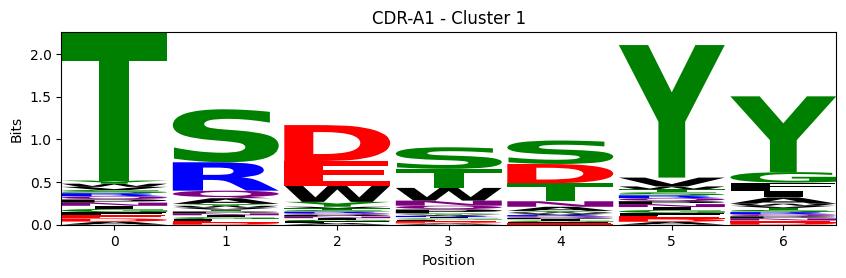

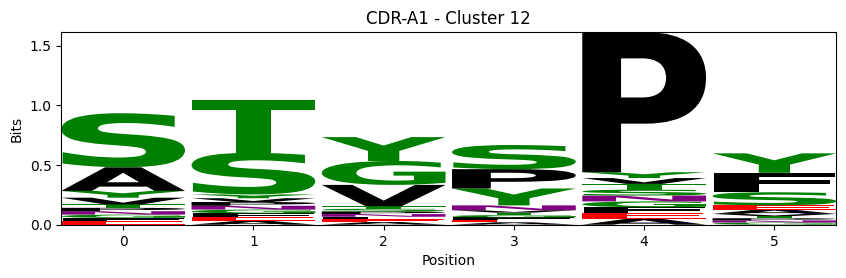

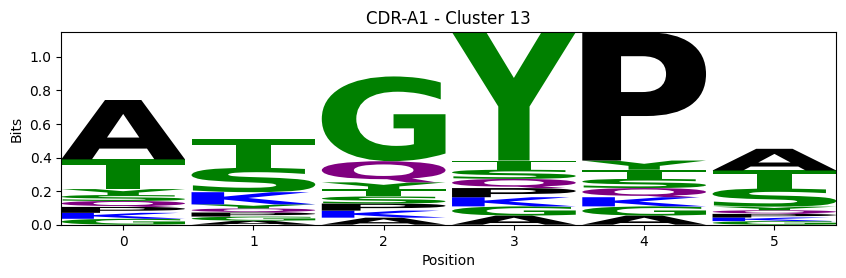

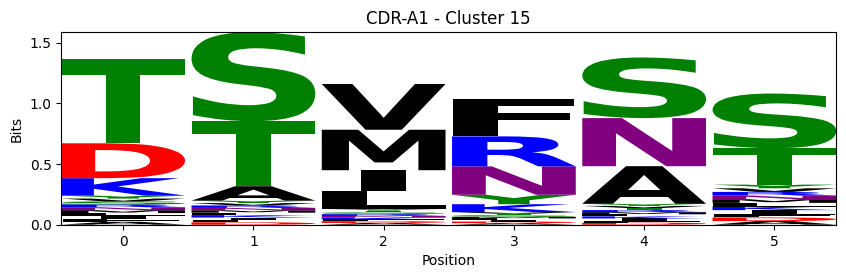

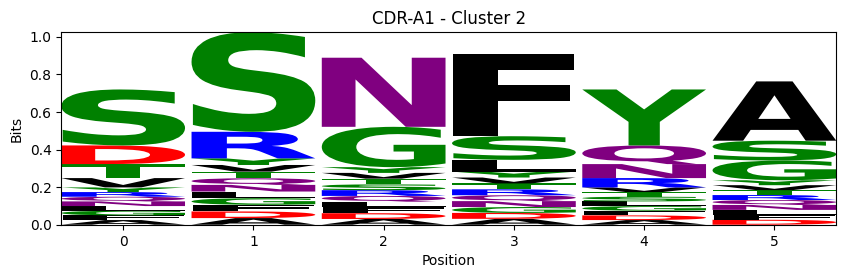

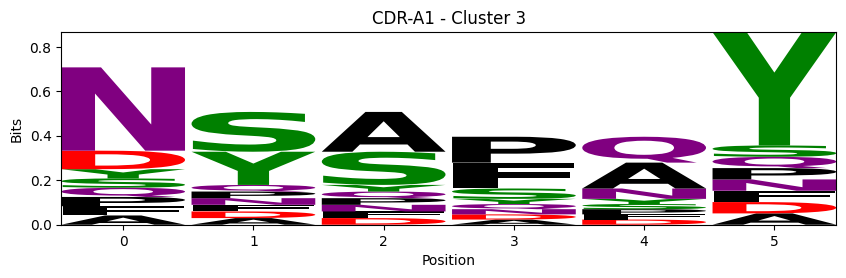

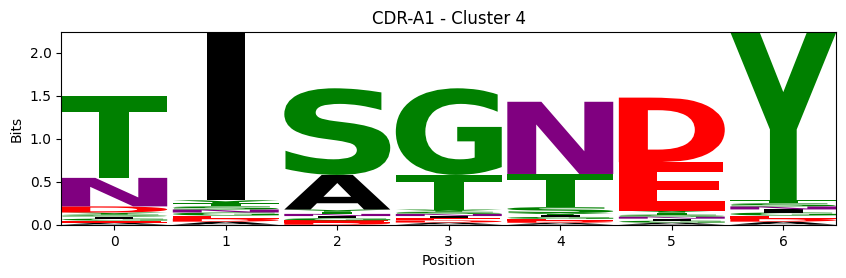

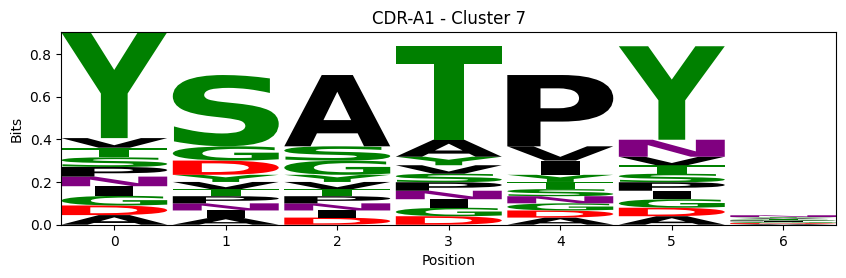

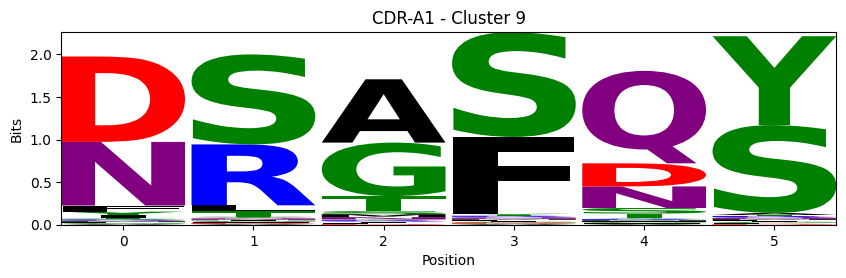

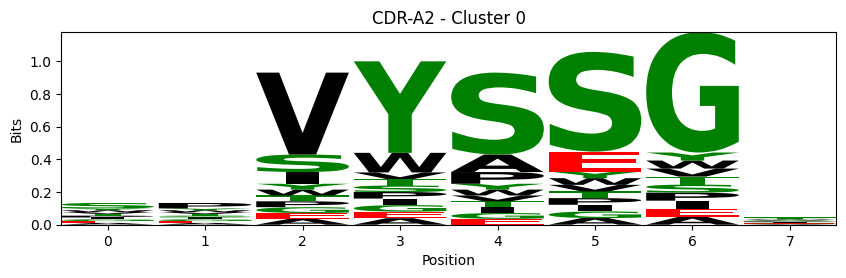

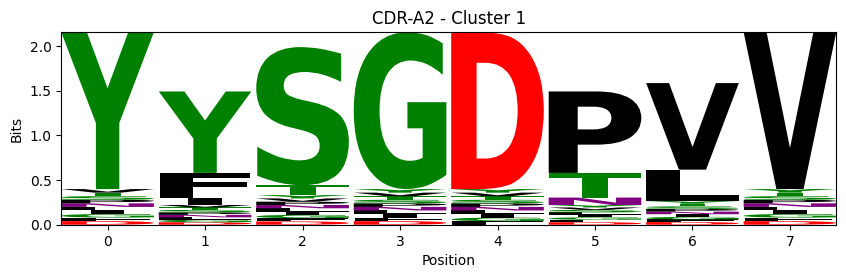

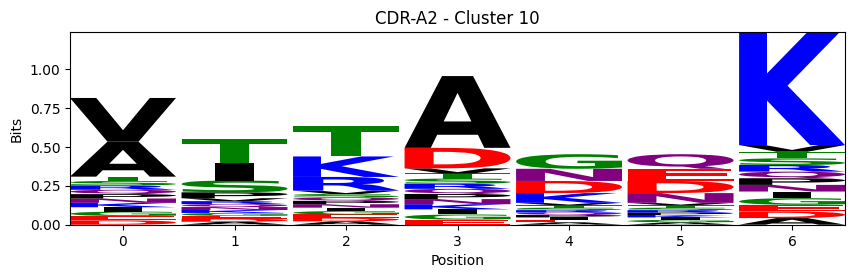

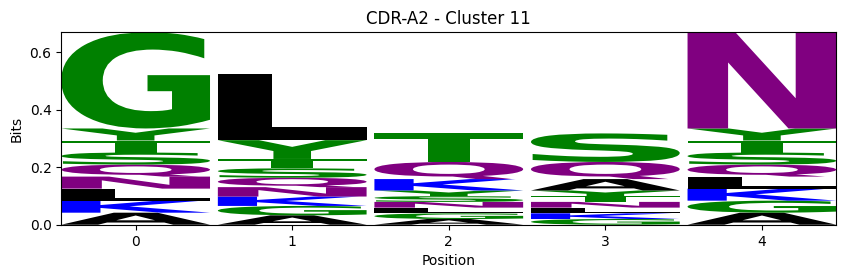

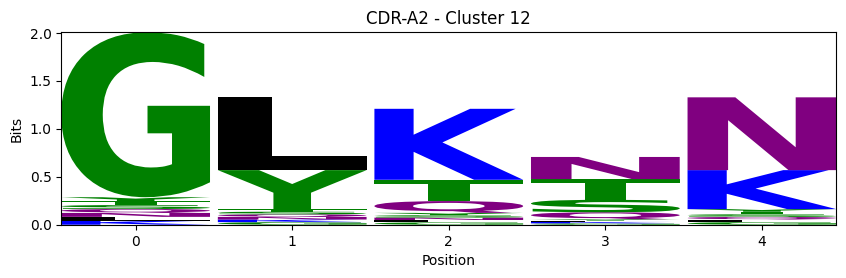

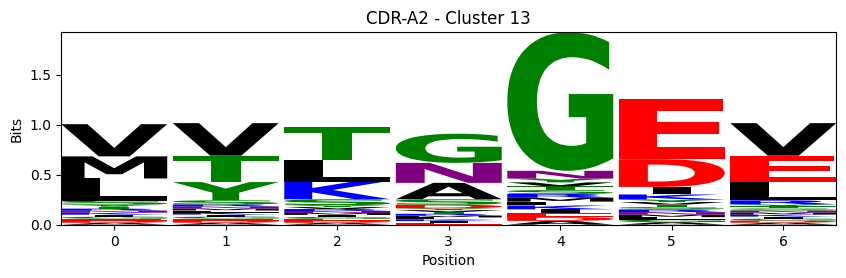

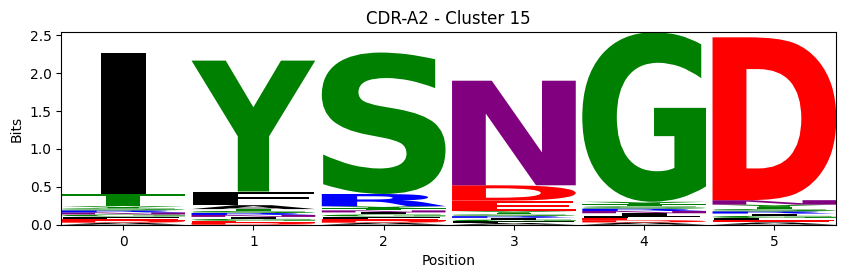

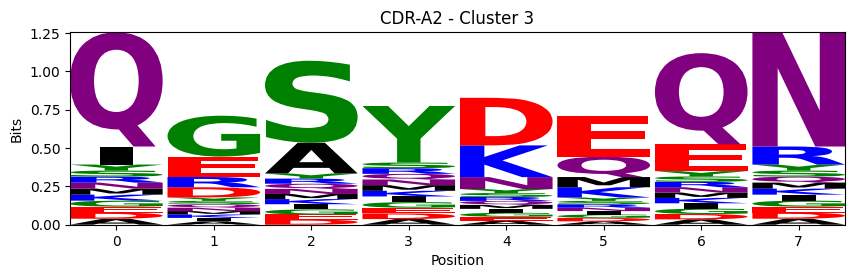

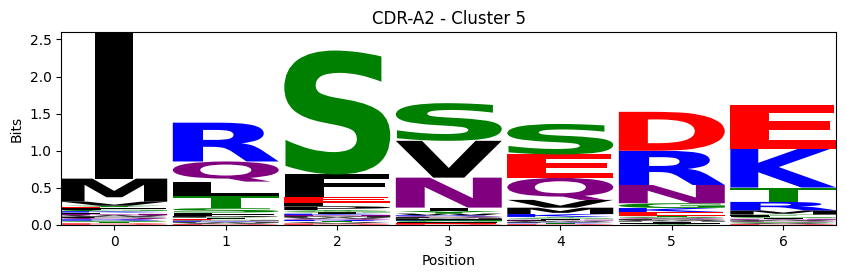

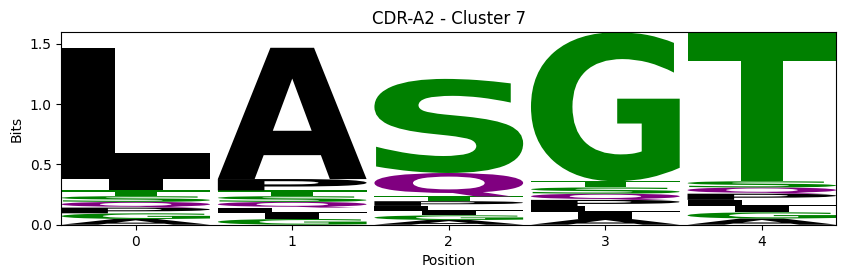

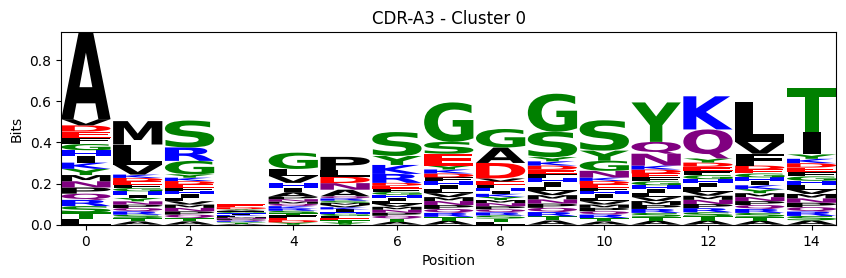

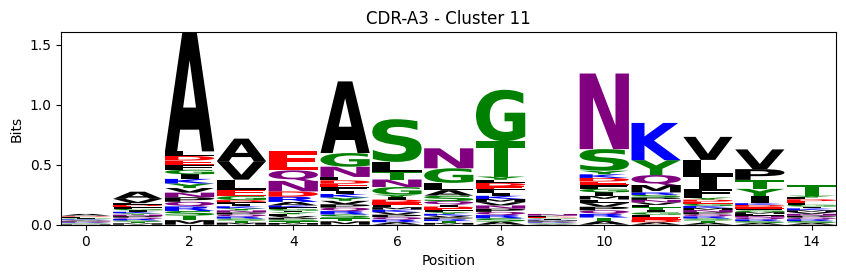

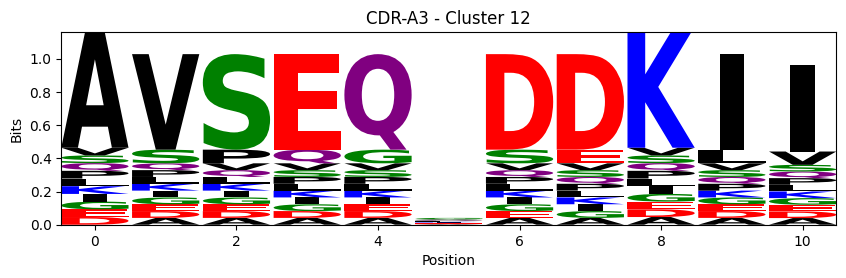

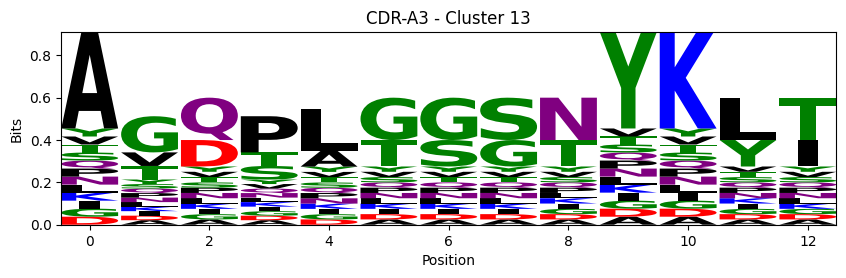

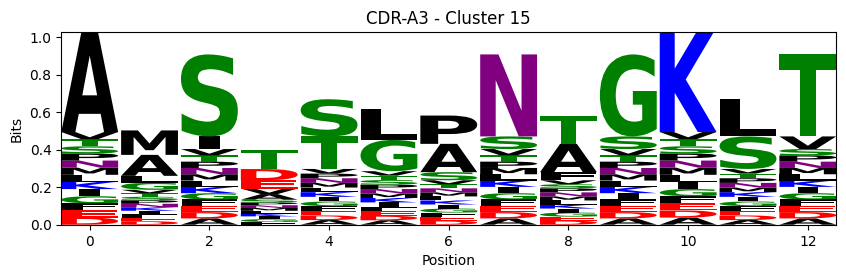

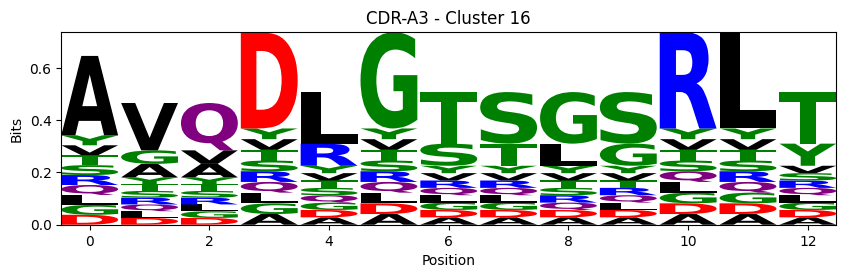

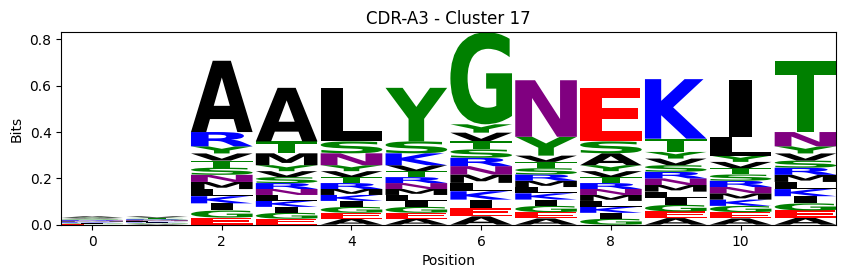

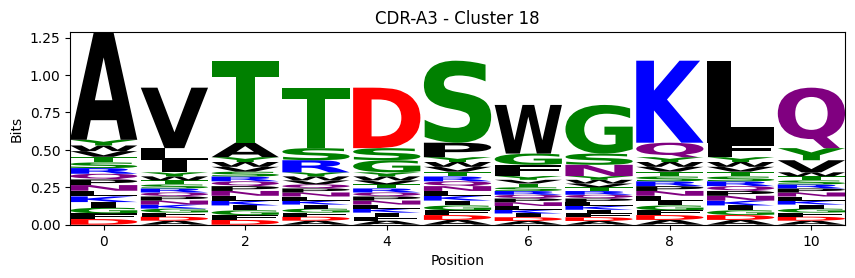

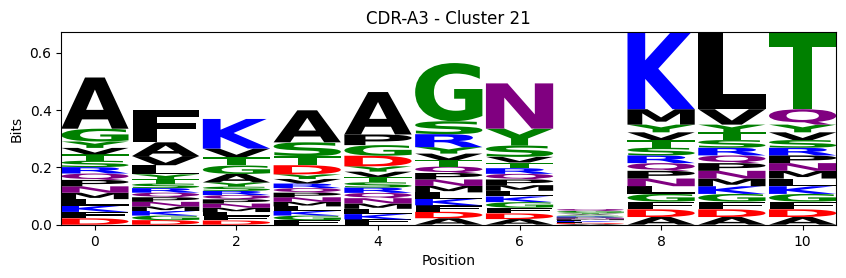

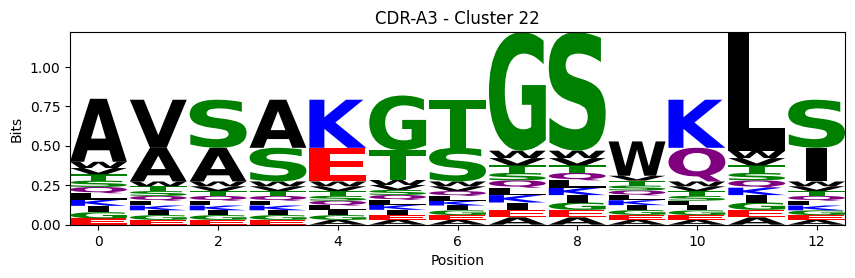

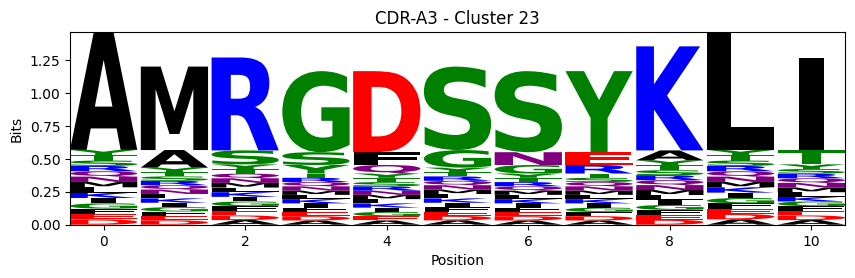

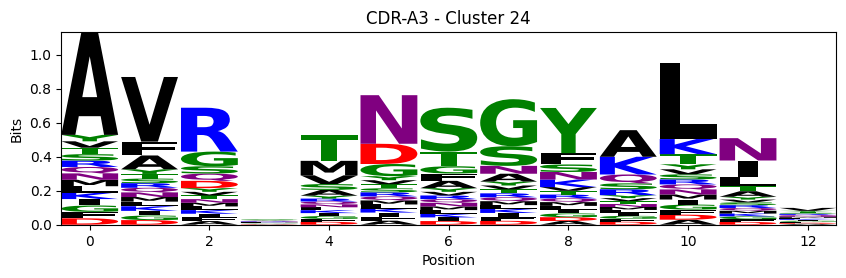

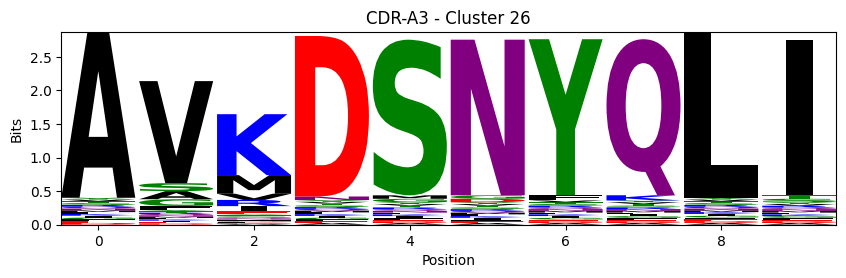

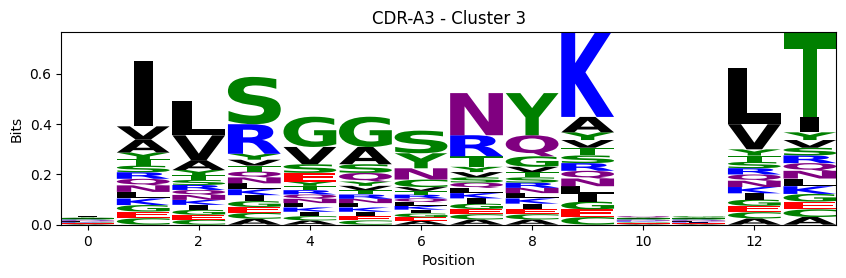

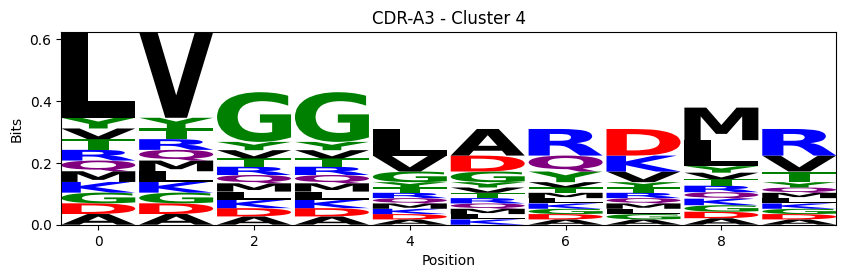

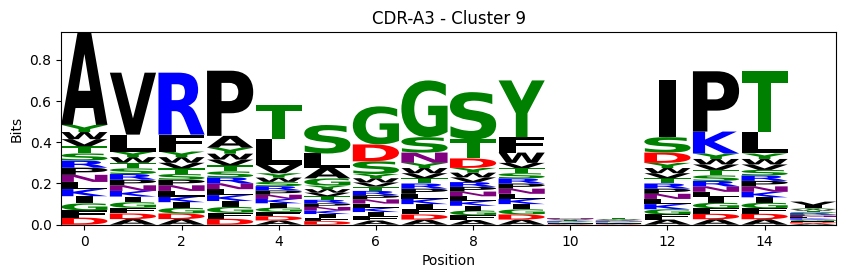

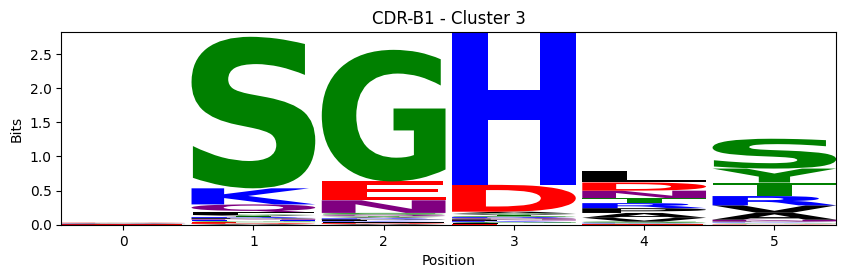

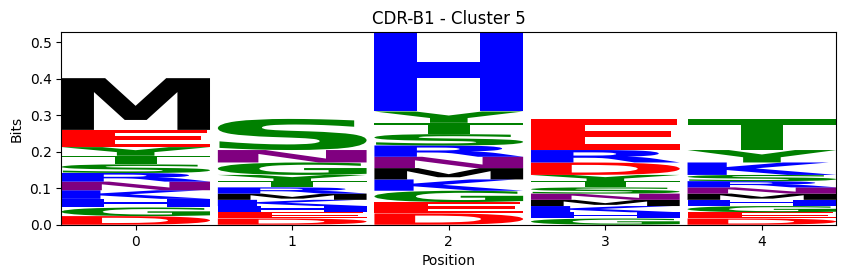

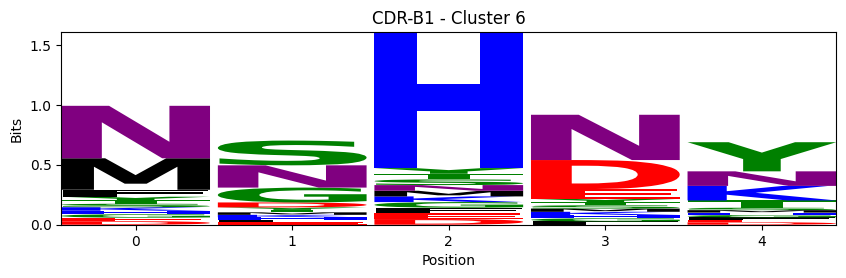

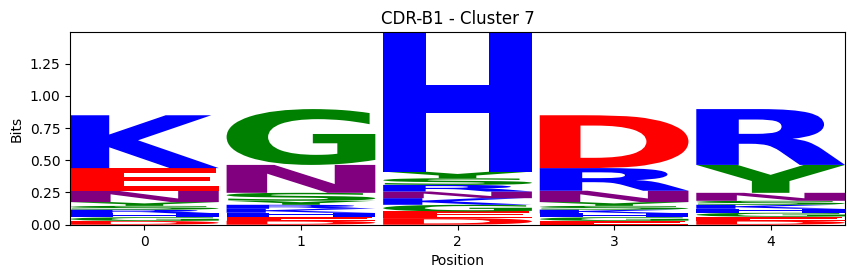

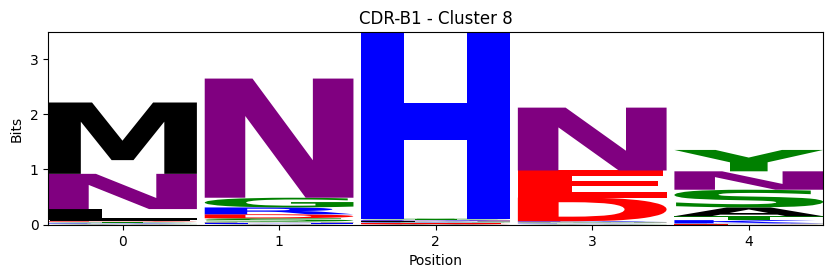

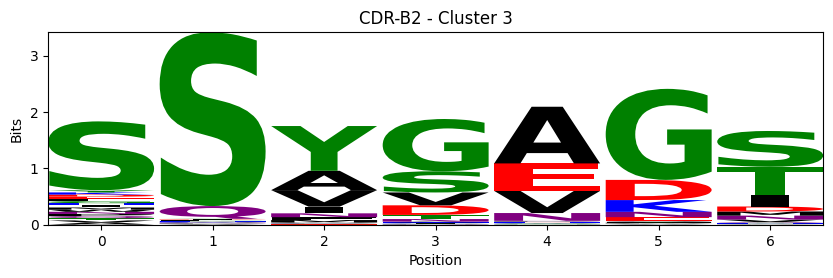

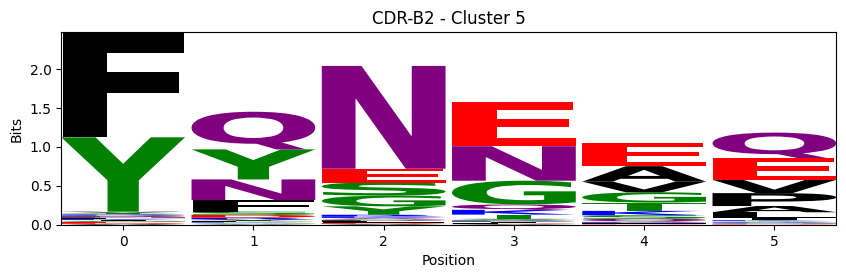

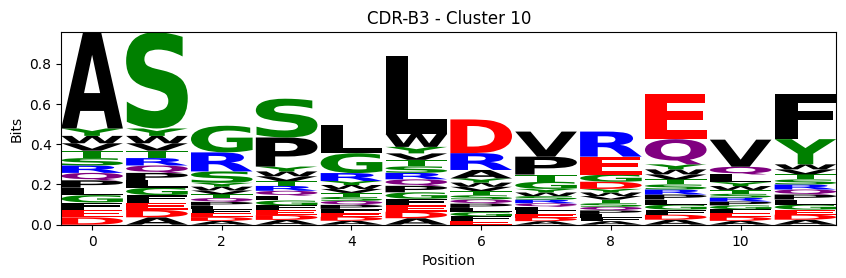

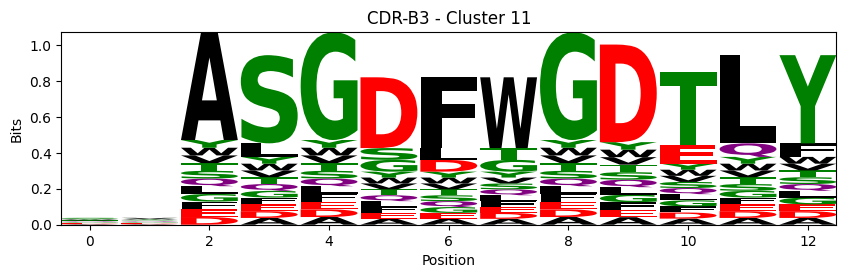

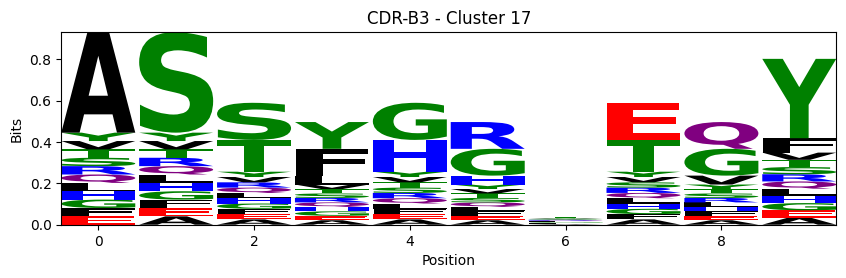

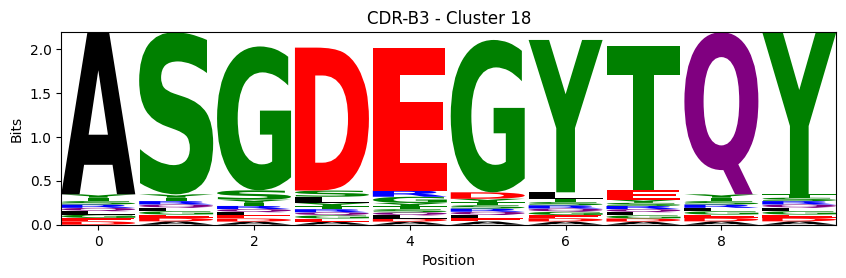

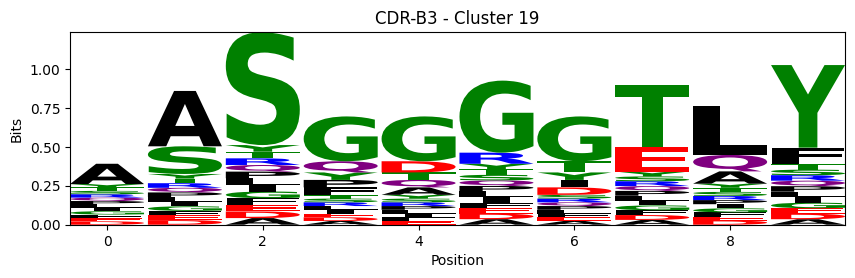

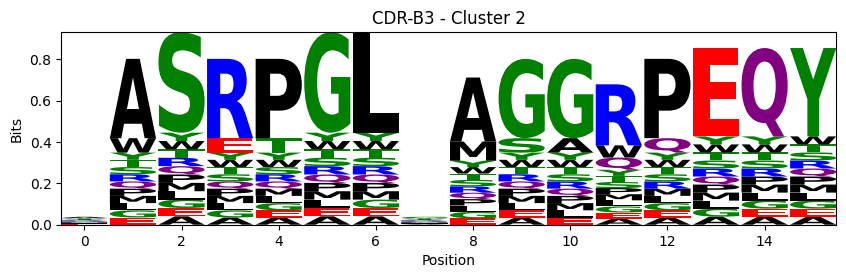

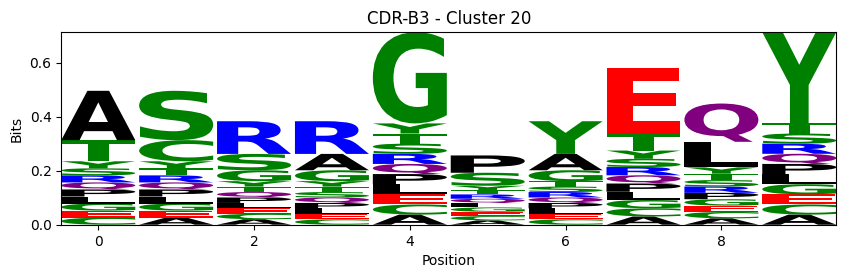

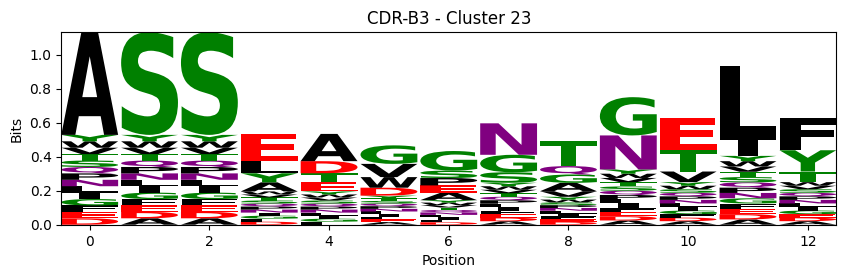

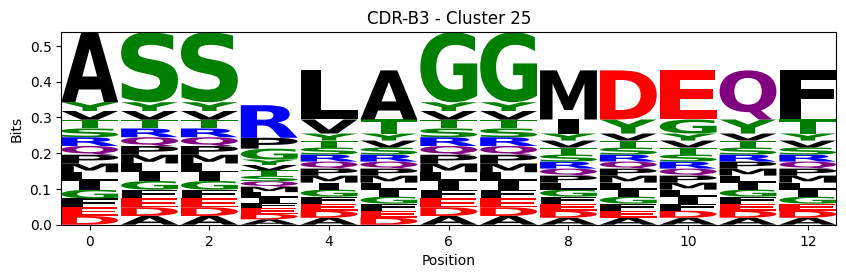

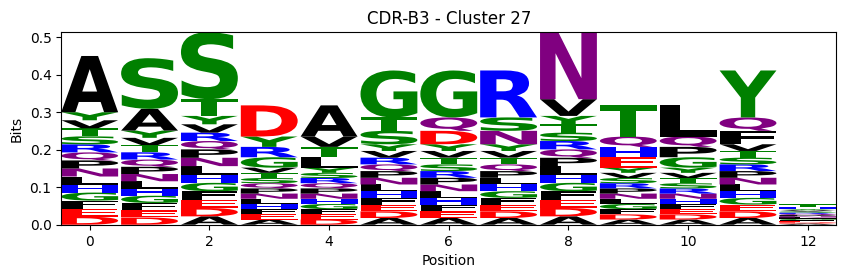

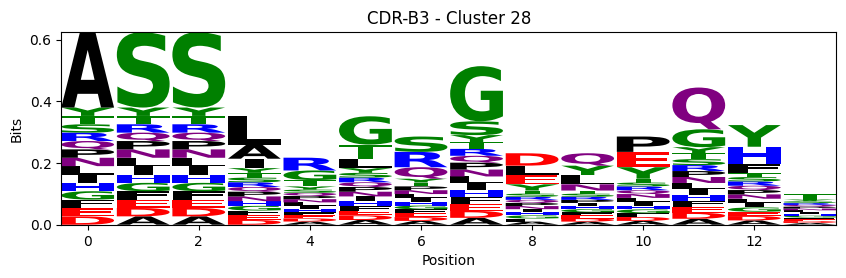

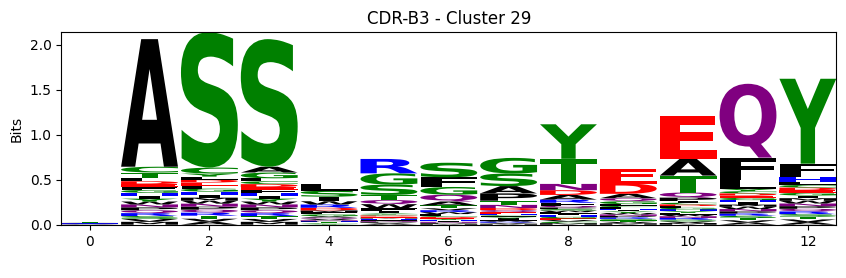

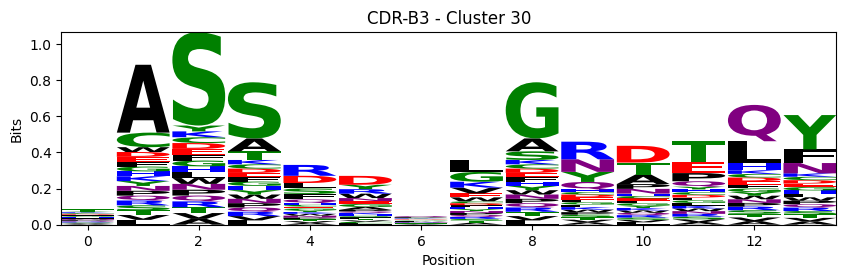

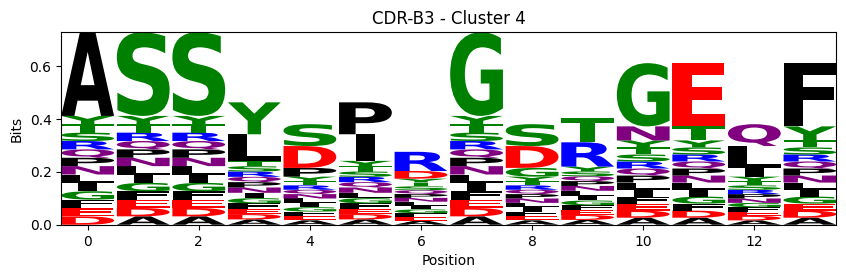

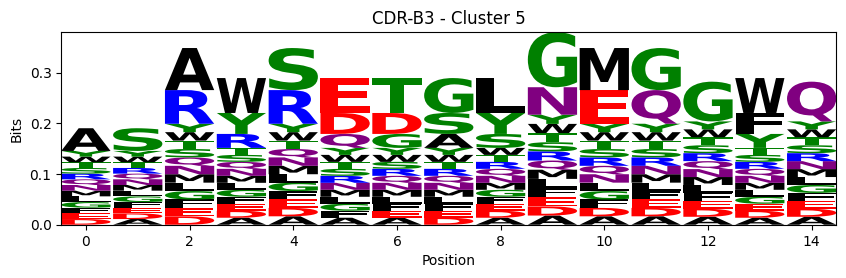

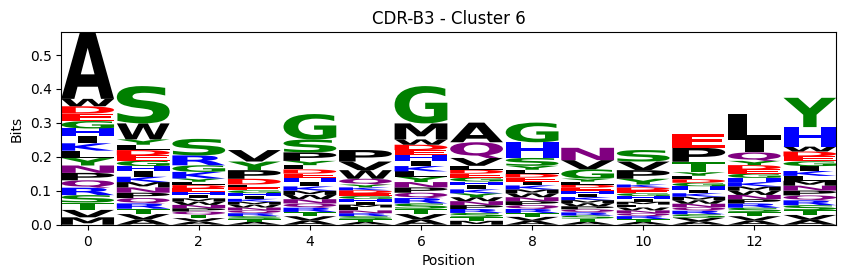

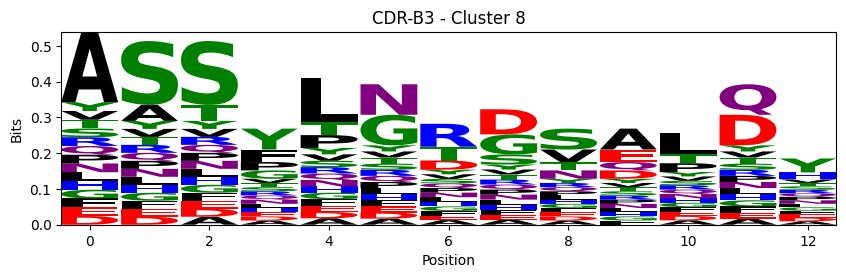

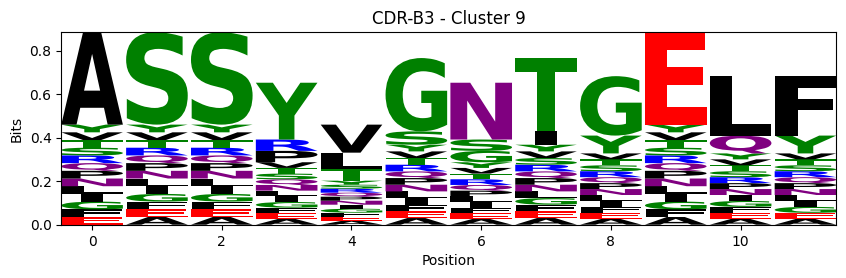

In [38]:
for (chain_type, cdr, cluster), group in df.query("cluster != 'noise' and cluster_type == 'canonical'").groupby(['chain_type', 'cdr', 'cluster']):
    with tempfile.TemporaryDirectory() as directory:
        input_file = os.path.join(directory, 'input.fasta')
        output_file = os.path.join(directory, 'output.fasta')

        with open(input_file, 'w') as fh:
            fh.write(format_fasta(group))

        cmd = f'clustalw2 -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA'
        subprocess.run(cmd.split(), check=True, stdout=subprocess.DEVNULL)

        with open(output_file, 'r') as fh:
            aligned_sequences = [line.strip() for line in fh.readlines() if not line.startswith('>')]


    probs = logomaker.alignment_to_matrix(aligned_sequences, to_type='information')
    logomaker.Logo(probs, color_scheme='chemistry')
    
    plt.title(f"CDR-{'A' if chain_type == 'alpha_chain' else 'B'}{cdr} - Cluster {cluster}")
    plt.ylabel('Bits')
    plt.xlabel('Position')
    
    plt.show()

## Look at backbone traces of each cluster

In [39]:
def find_anchors(cdr_df: pd.DataFrame,
                 structure_df: pd.DataFrame,
                 num_anchors: int = 1) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''Get the anchors of a cdr loop. DOES NOT SUPPORT MULTIPLE MODELS.'''
    cdr_start_info = tuple(cdr_df.iloc[0][['chain_id', 'residue_seq_id', 'residue_insert_code']].tolist())
    cdr_end_info = tuple(cdr_df.iloc[-1][['chain_id', 'residue_seq_id', 'residue_insert_code']].tolist())

    residues = list(structure_df.groupby(['chain_id', 'residue_seq_id', 'residue_insert_code'], dropna=False))

    for i, (residue_info, residue) in enumerate(residues):
        if pd.isna(residue_info[-1]):
            residue_info = (residue_info[0], residue_info[1], None)

        if cdr_start_info == residue_info:
            start_anchor = pd.concat([res for _, res in residues[i - num_anchors: i]])

        if cdr_end_info == residue_info:
            end_anchor = pd.concat([res for _, res in residues[(i + 1): (i + 1) + num_anchors]])
            break

    return start_anchor, end_anchor

In [40]:
def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

In [43]:
ca_coordinates = []
names = []
chain_types = []
cdrs = []
clusters = []

for (chain_type, cdr, cluster), group in df.query("cluster != 'noise' and cluster_type == 'canonical'").groupby(['chain_type', 'cdr', 'cluster']):

    
    pdb_id, chains = group.iloc[0]['name'].split('_')
    alpha_chain_id, beta_chain_id = tuple(chains)
    cdr = int(cdr)

    with open(os.path.join(STCRDAB_PATH, 'imgt', pdb_id + '.pdb'), 'r') as fh:
        reference_structure_df = parse_pdb_to_pandas(fh.read())

    reference_structure_df = annotate_tcr_df(reference_structure_df, alpha_chain_id, beta_chain_id)
    reference_tcr_df = reference_structure_df.query('chain_type.notnull()')

    reference_cdr_df = reference_tcr_df.query(("chain_type == @chain_type and cdr == @cdr"))
    refrence_anchors = pd.concat(find_anchors(reference_cdr_df, reference_tcr_df, 5))

    for _, row in group.iterrows():
        pdb_id, chains = row['name'].split('_')
        alpha_chain_id, beta_chain_id = tuple(chains)

        chain_type = row.chain_type
        cdr = int(row.cdr)

        with open(os.path.join(STCRDAB_PATH, 'imgt', pdb_id + '.pdb'), 'r') as fh:
            structure_df = parse_pdb_to_pandas(fh.read())

        structure_df = annotate_tcr_pmhc_df(structure_df, alpha_chain_id, beta_chain_id)
        tcr_df = structure_df.query('chain_type.notnull()')

        cdr_df = tcr_df.query(("chain_type == @chain_type and cdr == @cdr"))
        anchors = pd.concat(find_anchors(cdr_df, tcr_df, 5))

        cdr_df = align_pandas_structure(get_coords(anchors.query("atom_name == 'N' or atom_name == 'C' or atom_name == 'CA' or atom_name == 'O'")),
                                        get_coords(refrence_anchors.query("atom_name == 'N' or atom_name == 'C' or atom_name == 'CA' or atom_name == 'O'")),
                                        cdr_df)

        coords = get_coords(cdr_df.query("atom_name == 'CA'"))
        
        ca_coordinates.append(coords)
        chain_types.append(chain_type)
        cdrs.append(cdr)
        clusters.append(cluster)
        names.append(row['name'])

ca_coordinate_df = pd.DataFrame({
    'ca_coordinate': ca_coordinates,
    'chain_type': chain_types,
    'cdr': cdrs,
    'name': names,
    'cluster': clusters,
})

ca_coordinate_df = ca_coordinate_df.explode('ca_coordinate')
ca_coordinate_df[['ca_coordinate_x',
                  'ca_coordinate_y',
                  'ca_coordinate_z']] = ca_coordinate_df['ca_coordinate'].apply(pd.Series)
ca_coordinate_df = ca_coordinate_df.drop('ca_coordinate', axis=1)
ca_coordinate_df

chain_type  cdr     name cluster  ca_coordinate_x  ca_coordinate_y  \
0     alpha_chain    1  2ak4_DE       1        -8.921000        -2.834000   
0     alpha_chain    1  2ak4_DE       1       -10.687000        -1.374000   
0     alpha_chain    1  2ak4_DE       1        -8.026000        -2.786000   
0     alpha_chain    1  2ak4_DE       1        -8.333000        -6.207000   
0     alpha_chain    1  2ak4_DE       1        -4.570000        -6.343000   
...           ...  ...      ...     ...              ...              ...   
2681   beta_chain    3  6q3s_DE       9        24.712916         2.871787   
2681   beta_chain    3  6q3s_DE       9        21.160566         3.227679   
2681   beta_chain    3  6q3s_DE       9        22.222821         3.456264   
2681   beta_chain    3  6q3s_DE       9        19.276798         3.361323   
2681   beta_chain    3  6q3s_DE       9        19.688374         0.938961   

      ca_coordinate_z  
0           42.970000  
0           39.939000  
0           37.567000  
0           35.965000  
0           36.030000  
...               ...  
2681        24.716213  
2681        23.386885  
2681        19.740487  
2681        17.332256  
2681        14.416653  

[18584 rows x 7 columns]

In [44]:
ca_coordinate_df['cluster_name'] = (
    'CDR-'
    + ca_coordinate_df['chain_type'].map(lambda chain_type: 'A' if chain_type == 'alpha_chain' else 'B')
    + ca_coordinate_df['cdr'].apply(str)
    + ' - Cluster '
    + ca_coordinate_df['cluster']
)

In [78]:
for cluster_name, cluster_df in ca_coordinate_df.groupby('cluster_name'):
    fig = px.line_3d()

    cluster_df = ca_coordinate_df.query('cluster_name == @cluster_name')
    for _, cdr_loop in cluster_df.groupby('name'):
        fig.add_scatter3d(x=cdr_loop['ca_coordinate_x'],
                          y=cdr_loop['ca_coordinate_y'],
                          z=cdr_loop['ca_coordinate_z'],
                          mode='lines',
                          line=dict(color='green'),
                          showlegend=False)

    fig.update_layout(title=cluster_name)
    fig.write_html(f"figures/cdr-loop-clusters/{cluster_name}.html")

In [79]:
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        
        dropdown = Dropdown(options=cluster_names, description='Select Cluster')
        dropdown.observe(on_change)
        display(VBox([dropdown]))

        plot_cluster(change['new'])

def plot_cluster(cluster_name):
    fig = px.line_3d()

    cluster_df = ca_coordinate_df.query('cluster_name == @cluster_name')
    for _, cdr_loop in cluster_df.groupby('name'):
        fig.add_scatter3d(x=cdr_loop['ca_coordinate_x'],
                          y=cdr_loop['ca_coordinate_y'],
                          z=cdr_loop['ca_coordinate_z'],
                          mode='lines',
                          line=dict(color='green'),
                          showlegend=False)

    fig.update_layout(title=cluster_name)
    fig.show()

cluster_names = ca_coordinate_df['cluster_name'].unique().tolist()

dropdown = Dropdown(options=cluster_names, description='Select Cluster')
dropdown.observe(on_change)
display(VBox([dropdown]))

plot_cluster(cluster_names[0])

# Compare *apo* and *holo* forms of loops

In [49]:
APO_HOLO_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned'

In [50]:
apo_holo_names = pd.DataFrame({
    'path': glob.glob(os.path.join(APO_HOLO_DIR, '**/*.pdb'), recursive=True),
})
apo_holo_names['name'] = apo_holo_names.map(os.path.basename)
apo_holo_names['name'] = apo_holo_names['name'].str.replace('.pdb', '')
apo_holo_names[['pdb_id', 'chains', 'state']] = apo_holo_names['name'].str.split('_').apply(pd.Series)

apo_holo_names['tcr_chains'] = apo_holo_names['chains'].str[:2]
apo_holo_names['structure_name'] = apo_holo_names['pdb_id'] + '_' + apo_holo_names['tcr_chains']

apo_holo_names['tcr_group'] = apo_holo_names['path'].map(lambda path: path.split('/')[-2])

apo_holo_names

path            name pdb_id  \
0   /project/koohylab/bmcmaste/projects/tcr-pmhc-i...     7n1c_DE_apo   7n1c   
1   /project/koohylab/bmcmaste/projects/tcr-pmhc-i...  7n1e_DECA_holo   7n1e   
2   /project/koohylab/bmcmaste/projects/tcr-pmhc-i...     6at6_AB_apo   6at6   
3   /project/koohylab/bmcmaste/projects/tcr-pmhc-i...  6avf_ABPH_holo   6avf   
4   /project/koohylab/bmcmaste/projects/tcr-pmhc-i...     3vxt_AB_apo   3vxt   
..                                                ...             ...    ...   
70  /project/koohylab/bmcmaste/projects/tcr-pmhc-i...  3qdg_DECA_holo   3qdg   
71  /project/koohylab/bmcmaste/projects/tcr-pmhc-i...  5ivx_EFPA_holo   5ivx   
72  /project/koohylab/bmcmaste/projects/tcr-pmhc-i...     5iw1_AB_apo   5iw1   
73  /project/koohylab/bmcmaste/projects/tcr-pmhc-i...     7r7z_AB_apo   7r7z   
74  /project/koohylab/bmcmaste/projects/tcr-pmhc-i...  7r80_ABEC_holo   7r80   

   chains state tcr_chains structure_name  \
0      DE   apo         DE        7n1c_DE   
1    DECA  holo         DE        7n1e_DE   
2      AB   apo         AB        6at6_AB   
3    ABPH  holo         AB        6avf_AB   
4      AB   apo         AB        3vxt_AB   
..    ...   ...        ...            ...   
70   DECA  holo         DE        3qdg_DE   
71   EFPA  holo         EF        5ivx_EF   
72     AB   apo         AB        5iw1_AB   
73     AB   apo         AB        7r7z_AB   
74   ABEC  holo         AB        7r80_AB   

                                            tcr_group  
0   YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  
1   YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  
2   NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQR...  
3   NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQR...  
4    DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY  
..                                                ...  
70  DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  
71  NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSL...  
72  NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSL...  
73  DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...  
74  DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...  

[75 rows x 8 columns]

In [51]:
apo_holo_clusters = df.merge(apo_holo_names[['structure_name', 'tcr_group', 'state']],
                             how='inner',
                             left_on='name', right_on='structure_name')

apo_holo_clusters = apo_holo_clusters.drop('structure_name', axis=1)

apo_holo_clusters

name cluster     umap_1     umap_2   chain_type cdr    sequence  \
0    3w0w_DE      13  10.673161   1.232112   beta_chain   3  ASSGASHEQY   
1    3w0w_DE       9  15.241920  10.772205  alpha_chain   1      DRGSQS   
2    3w0w_DE       8   9.712945   9.481777   beta_chain   1       MNHEY   
3    3w0w_DE   noise   6.496253  -2.585478  alpha_chain   2      IYSNGD   
4    3w0w_DE       3  10.839975  -3.682086   beta_chain   2      SMNVEV   
..       ...     ...        ...        ...          ...  ..         ...   
445  4jff_DE       9  15.272546   9.645619  alpha_chain   1      FLGSQS   
446  4jff_DE       1   5.877508  28.979202   beta_chain   1      GTSNPN   
447  4jff_DE      15   8.340352  -2.915857  alpha_chain   2      TYREGD   
448  4jff_DE   noise  11.807358  -8.057465   beta_chain   2       WGPFG   
449  4jff_DE      28   1.369228   5.413054  alpha_chain   3   AVNDGGRLT   

    cluster_type                                          tcr_group state  
0         pseudo   DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY  holo  
1      canonical   DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY  holo  
2      canonical   DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY  holo  
3            NaN   DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY  holo  
4      canonical   DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY  holo  
..           ...                                                ...   ...  
445    canonical  FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGM...  holo  
446       pseudo  FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGM...  holo  
447    canonical  FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGM...  holo  
448          NaN  FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGM...  holo  
449       pseudo  FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGM...  holo  

[450 rows x 10 columns]

In [52]:
def collate_clusters(group):
    apo_clusters = sorted(group.query("state == 'apo'")['cluster'].tolist())
    holo_clusters = sorted(group.query("state == 'holo'")['cluster'].tolist())

    return pd.Series({'apo_clusters': apo_clusters, 'holo_clusters': holo_clusters})

apo_holo_clusters_agg = apo_holo_clusters.groupby(['tcr_group', 'chain_type', 'cdr']).apply(collate_clusters).reset_index()
apo_holo_clusters_agg

tcr_group   chain_type cdr  \
0    DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   1   
1    DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   2   
2    DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   3   
3    DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF   beta_chain   1   
4    DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF   beta_chain   2   
..                                                 ...          ...  ..   
103  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  alpha_chain   2   
104  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...  alpha_chain   3   
105  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   1   
106  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   2   
107  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

    apo_clusters        holo_clusters  
0            [2]         [9, 9, 9, 9]  
1           [15]     [15, 15, 15, 15]  
2        [noise]  [27, 27, 27, noise]  
3            [8]         [8, 8, 8, 8]  
4            [3]         [3, 3, 3, 3]  
..           ...                  ...  
103      [noise]              [noise]  
104      [noise]              [noise]  
105          [3]                  [3]  
106          [5]                  [5]  
107      [noise]              [noise]  

[108 rows x 5 columns]

Types of movements:

| *apo* |   | *holo* | name |
| ----- | - | ------ | ---- |
| noise | → | noise | noise|
| noise | → | canonical cluster | noise2canonical_cluster |
| noise | → | pseudo cluster | noise2pseudo_cluster |
| canonical cluster | → | noise | canonical_cluster2noise |
| pseudo cluster | → | noise | pseudo_cluster2noise |
| canonical cluster | → | *different* canonical cluster | canonical_cluster_shift |
| pseudo cluster | → | *different* pseudo cluster | pseudo_cluster_shift |
| canonical cluster | → | pseudo cluster | canonical2pseudo |
| pseudo cluster | → | canonical cluster | pseudo2canonical |
| canonical cluster | → | *same* canonical cluster | canonical_cluster_same |
| pseudo cluster | → | *same* pseudo cluster | pseudo_cluster_same |


In [53]:
def classify_movement(chain_type: str, cdr: str, apo_clusters: list[str], holo_clusters: list[str], cluster_types: pd.Series) -> pd.Series:
    types = {
        'noise': 0,
        'noise2canonical_cluster': 0,
        'noise2pseudo_cluster': 0,
        'canonical_cluster2noise': 0,
        'pseudo_cluster2noise': 0,
        'canonical_cluster_shift': 0,
        'pseudo_cluster_shift': 0,
        'canonical2pseudo': 0,
        'pseudo2canonical': 0,
        'canonical_cluster_same': 0,
        'pseudo_cluster_same': 0,
    }
    
    for apo_clust, holo_clust in itertools.product(apo_clusters, holo_clusters):
        if apo_clust == 'noise' and holo_clust == 'noise':
            types['noise'] += 1
        
        elif apo_clust == 'noise' and holo_clust != 'noise':
            if cluster_types.loc[chain_type, cdr, holo_clust] == 'canonical':
                 types['noise2canonical_cluster'] += 1
            
            else:
                types['noise2pseudo_cluster'] += 1
        
        elif apo_clust != 'noise' and holo_clust == 'noise':
            if cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical':
                 types['canonical_cluster2noise'] += 1
            
            else:
                types['pseudo_cluster2noise'] += 1
        
        elif apo_clust != holo_clust:
            if cluster_types.loc[chain_type, cdr, apo_clust] == cluster_types.loc[chain_type, cdr, holo_clust] == 'canonical':
                 types['canonical_cluster_shift'] += 1
            
            elif cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical' and cluster_types.loc[chain_type, cdr, holo_clust] == 'pseudo':
                types['canonical2pseudo'] += 1
            
            else:
                types['pseudo2canonical'] += 1
        
        elif apo_clust == holo_clust:
            if cluster_types.loc[chain_type, cdr, apo_clust] == 'canonical':
                types['canonical_cluster_same'] += 1

            else:
                types['pseudo_cluster_same'] += 1
        
    return pd.Series(types)


apo_holo_clusters_agg = apo_holo_clusters_agg.join(apo_holo_clusters_agg.apply(
    lambda row: classify_movement(row.chain_type, row.cdr, row.apo_clusters, row.holo_clusters, cluster_types), axis=1
))

# Wide to long
apo_holo_clusters_agg = apo_holo_clusters_agg.melt(id_vars=['tcr_group', 'chain_type', 'cdr'],
                                                 value_vars=['noise',
                                                             'noise2canonical_cluster',
                                                             'noise2pseudo_cluster',
                                                             'canonical_cluster2noise',
                                                             'pseudo_cluster2noise',
                                                             'canonical_cluster_shift',
                                                             'pseudo_cluster_shift',
                                                             'canonical2pseudo',
                                                             'pseudo2canonical',
                                                             'canonical_cluster_same',
                                                             'pseudo_cluster_same'],
                                                 var_name='types', value_name='count')

# Normalize for differeing group sizes
apo_holo_clusters_agg = apo_holo_clusters_agg.groupby(['tcr_group', 'chain_type', 'cdr', 'types'])['count'].median().reset_index()
apo_holo_clusters_agg

tcr_group   chain_type cdr  \
0     DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   1   
1     DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   1   
2     DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   1   
3     DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   1   
4     DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  alpha_chain   1   
...                                                 ...          ...  ..   
1183  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
1184  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
1185  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
1186  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   
1187  YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...   beta_chain   3   

                        types  count  
0            canonical2pseudo    0.0  
1     canonical_cluster2noise    0.0  
2      canonical_cluster_same    0.0  
3     canonical_cluster_shift    4.0  
4                       noise    0.0  
...                       ...    ...  
1183     noise2pseudo_cluster    0.0  
1184         pseudo2canonical    0.0  
1185     pseudo_cluster2noise    0.0  
1186      pseudo_cluster_same    0.0  
1187     pseudo_cluster_shift    0.0  

[1188 rows x 5 columns]

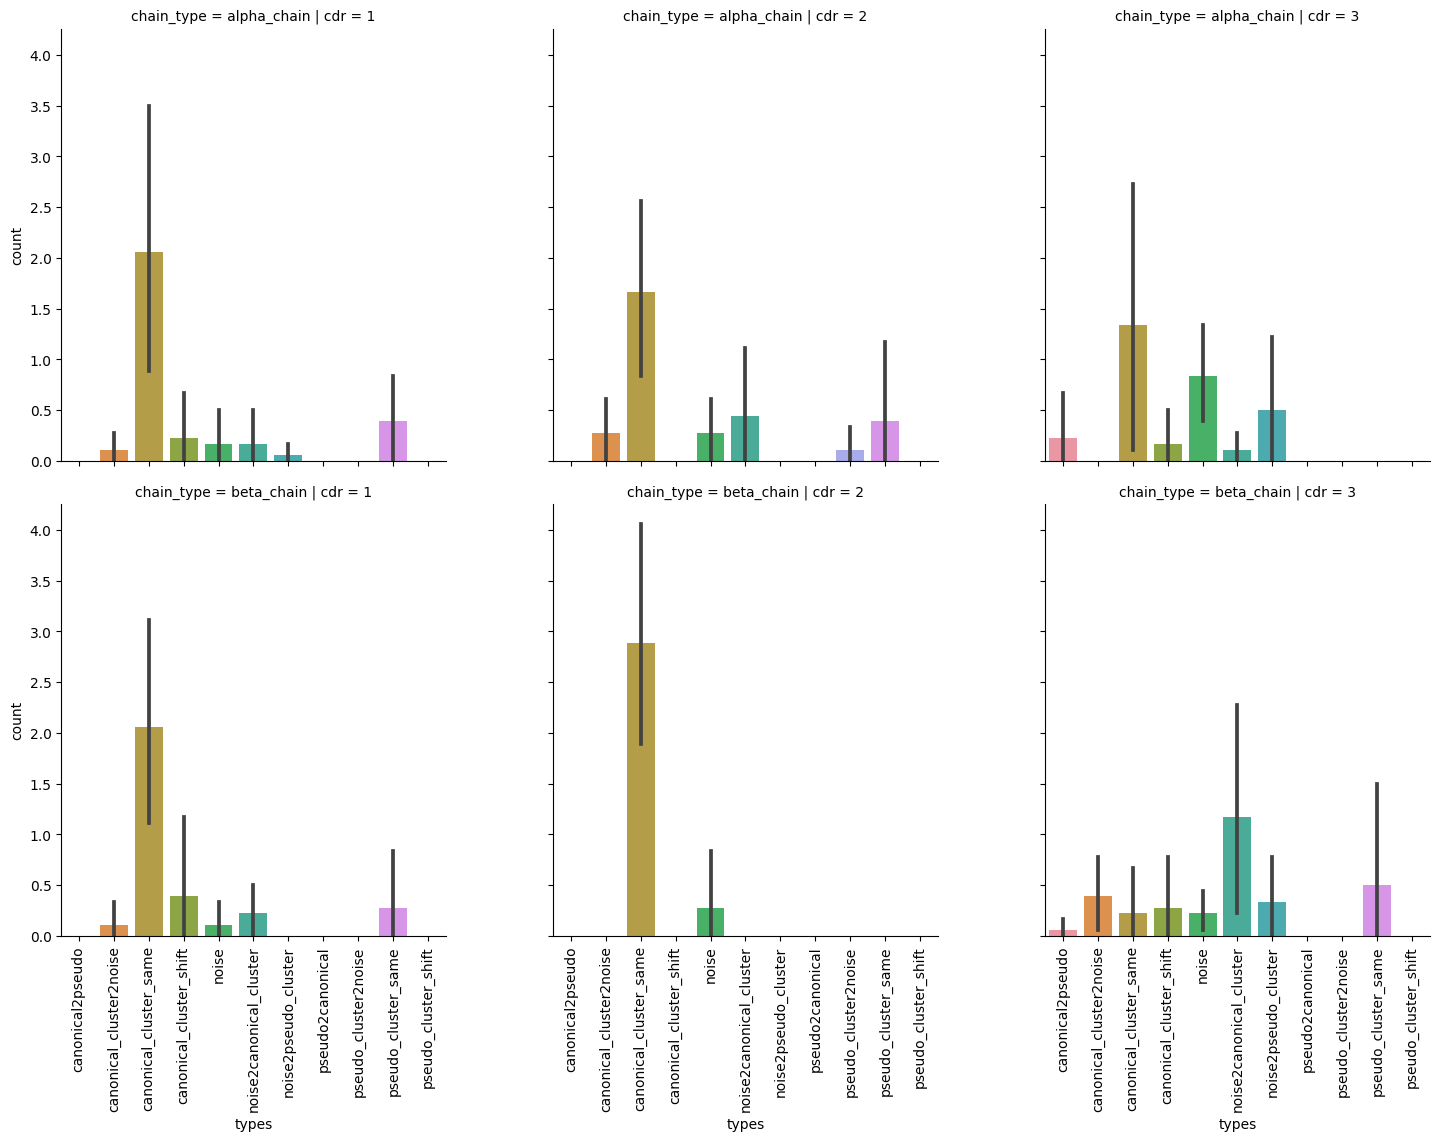

In [54]:
g = sns.catplot(apo_holo_clusters_agg.sort_values(['chain_type', 'cdr', 'types']),
                row='chain_type', col='cdr',
                x='types', y='count',
                kind='bar')

for ax in g.axes.flat:
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90)

In [55]:
cluster_shift_counts = apo_holo_clusters_agg.groupby(['chain_type', 'cdr', 'types'])['count'].sum().astype(int)
cluster_shift_counts[cluster_shift_counts > 0]

chain_type   cdr  types                  
alpha_chain  1    canonical_cluster2noise     2
                  canonical_cluster_same     37
                  canonical_cluster_shift     4
                  noise                       3
                  noise2canonical_cluster     3
                  noise2pseudo_cluster        1
                  pseudo_cluster_same         7
             2    canonical_cluster2noise     5
                  canonical_cluster_same     30
                  noise                       5
                  noise2canonical_cluster     8
                  pseudo_cluster2noise        2
                  pseudo_cluster_same         7
             3    canonical2pseudo            4
                  canonical_cluster_same     24
                  canonical_cluster_shift     3
                  noise                      15
                  noise2canonical_cluster     2
                  noise2pseudo_cluster        9
beta_chain   1    canonical_cluster2noise     